# Training

## 1. Loading datasets

### 1.1 Loading datasetst as `pandas DataFrame`

In [ ]:
import pandas as pd

train_df = pd.read_csv("/kaggle/input/toxic-comment/train.csv", on_bad_lines='warn')
test_df = pd.read_csv("/kaggle/input/toxic-comment/test.csv")
test_labels_df = pd.read_csv("/kaggle/input/toxic-comment/test_labels.csv")

train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### 1.2 Class distribution visualization

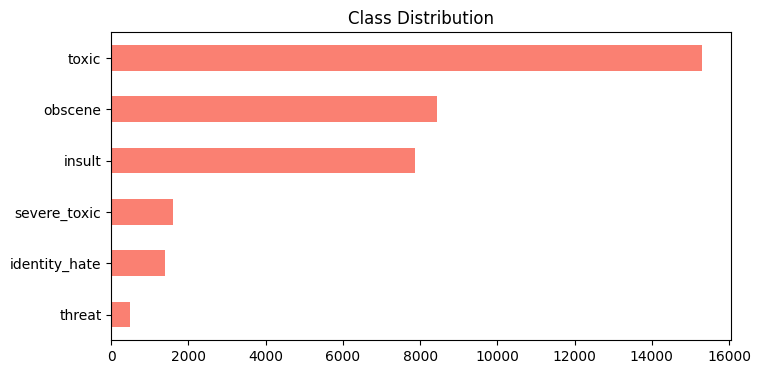

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of labels for classification
labels = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

plt.figure(figsize=(8,4))
train_df[labels].sum().sort_values().plot(kind='barh', color='salmon')
plt.title("Class Distribution")
plt.show()

## 2. Preparing the dataset

### 2.1 Multilabel Stratified Splitting for handling the class imbalance

In [ ]:

pip install iterative-stratification

Note: you may need to restart the kernel to use updated packages.


Using `MultilabelStratifiedKFold`

In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# X is the input (we only need index here)
X = train_df.index.values
# y is the multi-hot encoded label matrix
y = train_df[labels].values
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_index, val_index in mskf.split(X, y):
  train_split = train_df.iloc[train_index]
  val_split = train_df.iloc[val_index]
  break

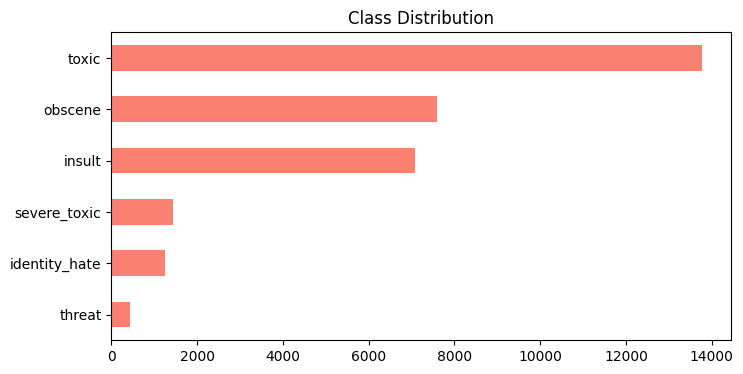

In [ ]:
plt.figure(figsize=(8,4))
train_split[labels].sum().sort_values().plot(kind='barh', color='salmon')
plt.title("Class Distribution")
plt.show()

### 2.2 Converting to Hugging Face dataset format

In [ ]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Converting to HF dataset
train_dataset = Dataset.from_pandas(train_split.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_split.reset_index(drop=True))

train_dataset

Dataset({
    features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
    num_rows: 143614
})

In [ ]:
# Wrapping into a Dataset Dict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 143614
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 15957
    })
})

## 3. Tokenization

### 3.1 Loading BERT tokenizer

In [ ]:

from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### 3.2 Create a tokenization and encoding function


In [ ]:
# Token and Encode Function
def preprocess_function(examples):
    # Tokenize
    tokenized = tokenizer(
        examples["comment_text"],
        truncation=True,
        max_length=128
    )

    # Attach multilabel targets as floats
    tokenized["labels"] = [
        [float(examples[label][i]) for label in labels]
        for i in range(len(examples["comment_text"]))
    ]
    return tokenized


### 3.3 Tokenization/Preprocessing

In [ ]:
# tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

tokenized_dataset

Map:   0%|          | 0/143614 [00:00<?, ? examples/s]

Map:   0%|          | 0/15957 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 143614
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 15957
    })
})


Checking how many examples have all labels zero (non-toxic comments)


In [ ]:

def all_zero(example):
    return all(label == 0 for label in example["labels"])

# Count how many match the conditio
num_all_zero = tokenized_dataset.filter(all_zero).num_rows
print(f"Examples with all 0 labels: {num_all_zero} out of {tokenized_dataset.num_rows}")

Filter:   0%|          | 0/143614 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15957 [00:00<?, ? examples/s]

Examples with all 0 labels: {'train': 129015, 'validation': 14331} out of {'train': 143614, 'validation': 15957}


## 4. Fine-Tuning

In [ ]:

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    problem_type='multi_label_classification'
)

2025-07-06 09:59:44.705115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751795984.871717      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751795984.926502      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.4 Dynamic Padding

In [ ]:

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 4.4 Defining Metrics Function

In [ ]:
# Setup compute_metrics function
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))  # sigmoid for multilabel
    preds = (probs >= 0.4).astype(int)
    labels = labels.astype(int)


    results = {
        "micro_f1": f1_score(labels, preds, average='micro'),
        "macro_f1": f1_score(labels, preds, average='macro'),
        "precision": precision_score(labels, preds, average='macro', zero_division=0),
        "recall": recall_score(labels, preds, average='macro', zero_division=0),
        "hamming_loss": hamming_loss(labels, preds),
    }

    # Add ROC AUC
    try:
        results["roc_auc_macro"] = roc_auc_score(labels, probs, average='macro')
        results["roc_auc_micro"] = roc_auc_score(labels, probs, average='micro')
    except ValueError:
        # Handle case where some classes have no positive samples
        results["roc_auc_macro"] = 0.0
        results["roc_auc_micro"] = 0.0

    return results


### 4.5 Setup `wandb`

In [ ]:
import wandb
from getpass import getpass

# Manually enter your token (hidden input)
wandb_token = getpass("Enter your wandb access token: ")

# Log in using API
wandb.login(key=wandb_token)

Enter your wandb access token:  ········


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dipesh1dp (dipesh1dp-purwanchal-campu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### 4.6 Training Arguments + Trainer

In [ ]:

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./checkpoints-toxic",
    fp16=True,
    report_to="wandb",
    run_name="bert-finetune-toxic-4",
    eval_strategy="epoch",
    save_strategy="epoch",   # <-- Save every epoch
    learning_rate=2e-5,      # <-- Keep only recent checkpoints
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    save_total_limit=2,
    disable_tqdm=False                      # Show progress bar
)


trainer = Trainer(
    model = model,
    processing_class=tokenizer,
    args = training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### 4.6 Train

In [ ]:

trainer.train()

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Precision,Recall,Hamming Loss,Roc Auc Macro,Roc Auc Micro,Runtime,Samples Per Second,Steps Per Second
1,0.041100,0.038554,0.785654,0.632359,0.679378,0.637917,0.015918,0.988511,0.991905,56.271800,283.570000,8.868000
2,0.033300,0.039169,0.795081,0.678849,0.693427,0.674944,0.015490,0.988311,0.991712,55.747200,286.239000,8.951000
3,0.024800,0.044270,0.785545,0.690982,0.631213,0.775650,0.016983,0.989067,0.991172,55.823500,285.847000,8.939000
4,0.016000,0.052118,0.784465,0.691238,0.658448,0.729504,0.016346,0.987536,0.989168,56.085500,284.512000,8.897000
5,0.010100,0.058526,0.781811,0.687897,0.658318,0.722763,0.016388,0.986001,0.987920,55.766800,286.138000,8.948000


TrainOutput(global_step=44880, training_loss=0.026582102968943522, metrics={'train_runtime': 9161.1033, 'train_samples_per_second': 78.382, 'train_steps_per_second': 4.899, 'total_flos': 4.700929028863219e+16, 'train_loss': 0.026582102968943522, 'epoch': 5.0})

In [ ]:

trainer.save_model("./best-toxic-model")

## 5. Saving Model and Tokenizer

In [ ]:

from huggingface_hub import login

login()

In [ ]:

trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dipeshpandit/checkpoints-toxic/commit/ec1f5c9b9eafdeae9824b4794c8a60e52130a096', commit_message='End of training', commit_description='', oid='ec1f5c9b9eafdeae9824b4794c8a60e52130a096', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dipeshpandit/checkpoints-toxic', endpoint='https://huggingface.co', repo_type='model', repo_id='dipeshpandit/checkpoints-toxic'), pr_revision=None, pr_num=None)

# Model Evaluation

### Test data preprocessing

In [ ]:

from datasets import Dataset

test_dataset = Dataset.from_pandas(test_df)


In [ ]:

import numpy as np

# Add labels to test_dataset
test_labels = test_labels_df[labels].values.astype(np.float32)
test_dataset = test_dataset.add_column('labels', test_labels.tolist())
test_dataset[2]

{'id': '00013b17ad220c46',
 'comment_text': '" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "',
 'labels': [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}

Let's check how many examples are unlabelled as

``` labels: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0] ```

In [ ]:
def all_neg1(example):
    return all(label == -1 for label in example["labels"])

# Count how many match the conditio
num_all_neg1 = test_dataset.filter(all_neg1).num_rows
print(f"Examples with all -1 labels: {num_all_neg1} out of {test_dataset.num_rows}")

Filter:   0%|          | 0/153164 [00:00<?, ? examples/s]

Examples with all -1 labels: 89186 out of 153164


In [ ]:
# Remove the examples having all -1 labels
def has_valid_labels(example):
    return any(label != -1 for label in example["labels"])

test_dataset = test_dataset.filter(has_valid_labels)
test_dataset[2]

Filter:   0%|          | 0/153164 [00:00<?, ? examples/s]

{'id': '0002f87b16116a7f',
 'comment_text': '"::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding ""Religion"" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent ""Influences"" issue?  You\'re just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    \n\n "',
 'labels': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [ ]:

def tokenize_function(examples):
    return tokenizer(examples['comment_text'], truncation=True, max_length=128)

In [ ]:

test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/63978 [00:00<?, ? examples/s]

## 1. Per Label Threshold Analysis

In [ ]:

import numpy as np
from sklearn.metrics import f1_score

def find_optimal_thresholds(y_true, y_probs, step=0.01):
    """
    Finds the best threshold per label to maximize F1 score.

    Args:
        y_true: np.array of shape (n_samples, n_labels)
        y_probs: np.array of shape (n_samples, n_labels) - model output after sigmoid
        step: float - step size for threshold search

    Returns:
        thresholds: list of optimal threshold per label
    """
    n_labels = y_true.shape[1]
    thresholds = []

    for i in range(n_labels):
        best_thresh = 0.5
        best_f1 = 0.0
        for t in np.arange(0.1, 0.9 + step, step):
            preds = (y_probs[:, i] >= t).astype(int)
            f1 = f1_score(y_true[:, i], preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
        thresholds.append(best_thresh)
        print(f"Label {i}: Best threshold = {best_thresh:.2f} | F1 = {best_f1:.4f}")

    return thresholds


In [ ]:

import torch

# y_probs: logits from model output, apply sigmoid
logits = trainer.predict(tokenized_dataset["validation"]).predictions
y_probs = torch.sigmoid(torch.tensor(logits)).numpy()

# y_true: ground truth multilabels (should be 0/1 matrix)
y_true = tokenized_dataset["validation"]["labels"]
y_true = np.array(y_true)

# Find optimal thresholds
optimal_thresholds = find_optimal_thresholds(y_true, y_probs)


Label 0: Best threshold = 0.69 | F1 = 0.8264
Label 1: Best threshold = 0.44 | F1 = 0.5238
Label 2: Best threshold = 0.60 | F1 = 0.8321
Label 3: Best threshold = 0.47 | F1 = 0.6316
Label 4: Best threshold = 0.32 | F1 = 0.7713
Label 5: Best threshold = 0.55 | F1 = 0.6280


Per label threshold on validation data:
```
Label 0: Best threshold = 0.69 | F1 = 0.8264
Label 1: Best threshold = 0.44 | F1 = 0.5238
Label 2: Best threshold = 0.60 | F1 = 0.8321
Label 3: Best threshold = 0.47 | F1 = 0.6316
Label 4: Best threshold = 0.32 | F1 = 0.7713
Label 5: Best threshold = 0.55 | F1 = 0.6280
```

In [ ]:

import json

with open("optimal_thresholds.json", "w") as f:
    json.dump(optimal_thresholds, f)


In [ ]:

opt_thresholds = np.array([0.69, 0.44, 0.60, 0.47, 0.32, 0.55])

## 2. Model Performance

### Setup compute metrics function with optimal thresholds per label

In [ ]:

from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()

    # Use global optimal_thresholds defined outside the function
    preds = (probs >= opt_thresholds).astype(int)

    return {
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_micro": precision_score(labels, preds, average="micro"),
        "recall_micro": recall_score(labels, preds, average="micro"),
        "precision_macro": precision_score(labels, preds, average="macro"),
        "recall_macro": recall_score(labels, preds, average="macro"),
    }


In [ ]:
# Then evaluate
test_results = trainer.predict(test_dataset)
test_metrics = compute_metrics((test_results.predictions, test_results.label_ids))

for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

f1_micro: 0.6740
f1_macro: 0.6089
precision_micro: 0.5857
recall_micro: 0.7938
precision_macro: 0.5426
recall_macro: 0.7092
